# Assessment: Weekly deliverable template - Regression
<font color='#AC135A'>**Applied Machine Learning** - **Sheffield Hallam University**</font>


---

## Introduction
Add your solutions to the different sub-tasks requested for this deliverable.

<font color='red'>DO NOT ADD MORE CELLS TO THE FINAL VERSION OF THIS NOTEBOOK.

### 1. Dataset loading

In [ ]:
import pandas as pd

df = pd.read_csv('wines_SPA.csv')

# Initial data exploration

# I'm dropping duplicates right away to ensure the statistics are not distorted.
# As there is a very specific variable 'num_reviews' I know that if all columns are identical 
# the row is a duplicate, likely resulting from merging datasets with the same data.
# It would be a very big conincidence if two different data sources had the exact same values for all columns including 'num_reviews'.
# So keeping these duplicates in here would multiply the weight of these examples. (The case would be different if 'number of ratings' was not present,
# as then maybe these duplicates would represent different sources of ratings and would be relevant for the analysis.)
df = df.drop_duplicates()

# Describe numerical columns
print(df.describe())
print()
# Save numerical columns
numerical_columns = df.describe().columns

# I check the number of unique values in the remaining categorical column to understand their variability.
print("Categorical Columns:")
for column in df.columns:
    if column not in numerical_columns:
        print(f"Unique values in '{column}': {len(df[column].unique())}")

# Check for missing values
print("\nMissing Values")
print(df.isna().sum())



            rating   num_reviews        price         body      acidity
count  2048.000000   2048.000000  2048.000000  1777.000000  1777.000000
mean      4.401123    573.994629   135.242194     4.258863     2.921216
std       0.147023   1376.153171   272.178316     0.652836     0.334713
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.300000     58.000000    31.917947     4.000000     3.000000
50%       4.400000    141.000000    53.625000     4.000000     3.000000
75%       4.500000    485.500000   110.000000     5.000000     3.000000
max       4.900000  32624.000000  3119.080000     5.000000     3.000000

Categorical Columns:
Unique values in 'winery': 480
Unique values in 'wine': 847
Unique values in 'year': 72
Unique values in 'country': 1
Unique values in 'region': 76
Unique values in 'type': 22

Missing Values
winery           0
wine             0
year             2
rating           0
num_reviews      0
country          0
region           0
price

**Selected Approach**

The dataset has 11 variables. The assessment asks to create models for Quality and Price. While there is a variable for *price*, quality as such does not exist. I will use *rating* as variable for quality instead for lack of any other options. 

I was initially hesitant to use *winery* and *wine* as predictor variables due to the big number of unique values. I was afraid there were not enough examples per class to be significant. However, during the course of the project I understood that it is actually possible to add only a subset of classes (those with sufficient examples) to the models. I would do thisin the next iteration.

I am not using *country* was not an option as it only has one value. 

*Num_neviews*  is a tricky variable. I feel is not a valid variable to put in either model. There may be some correlation between the number of reviews and *ratings* or *price*, respectively, but that doesn't imply causality. That said, when calculating the rating, the number of reviews for the same wine could be a valid parameter in the sense that the examples should be weighted according to the number of reviews. However, this goes beyond the scope of this assessment.

That said, I do use *price* to predict *rating* and vice versa, although I'm not sure if this is valid either (*rating* does not *cause* the price, the other way around may make more sense). But these are the only variables that have some sort of correlation, so I decided to keep them in. 

*Year* i thought is certainly an important variable for the price model, and, maybe less so, also for predicting *rating*. It is an ordinal categorical variable in the sense that older wines should be more expensive. So instead of using *year* I will engineer *age* and use that.

I also decided to include *type* because I can see that there may be an influence both on *price* and *rating*, based on domain knowledge. Also, the number of unique values is low enough. 

*Region* was a bit of an edge case with 76 values. Knowing what I know now, I would include the categories with many examples, but that is for the next iteration. For now I decided to not use this variable.

*Acidity* I did not include, as the vast majority of examples have the same value. Mean – 2*std, which covers 95% of examples is above 2, and the max is at 3, so almost all examples will have a value of 3. 

*Body* doesn't have a particulary wide range either, most examples have 4 or 5 (25% quartile is at 4), but I will include this variable as I think it could well influence *rating* in particular, based on domain knowledge. 

I decided to drop all missing values rather than imputing, as in particular for body imputing e.g. median data might skew the results. 




In [2]:
# Removing columns I do not want to further use.
df = df.drop(columns=['country', 'num_reviews', 'region', 'wine', 'winery', 'acidity'], axis=1)

# Drop missing values
df = df.dropna()

print(df.describe())

print("\nCategorical Columns:")
for column in df.columns:
    if column not in numerical_columns:
        print(f"Unique values in '{column}': {len(df[column].unique())}")


            rating        price         body
count  1775.000000  1775.000000  1775.000000
mean      4.411887   148.786017     4.258592
std       0.150982   289.401877     0.652938
min       4.200000     4.990000     2.000000
25%       4.300000    33.015000     4.000000
50%       4.400000    58.260000     4.000000
75%       4.500000   125.000000     5.000000
max       4.900000  3119.080000     5.000000

Categorical Columns:
Unique values in 'year': 71
Unique values in 'type': 21


**Observation** 

*NUMERICAL ATTRIBUTES*

*rating*

The rating values have a range between 4.2 and 4.9. Removing the duplicates has dramatically improved the distribution of values (I have run some tests before). The 75% quartile was at 4.2 (the minimum!), and is now at 4.5. Adding/substracting the std to/from the mean shows that 68% of examples have a rating between 4.3 and 4.6, and 95% of examples have rating below 4.8. From these data I expect a reasonably good distribition at a location of 4.4, the median. 

*price*

We see similar behaviour of the price data: A huge range (4.99–3119.08), a relatively strong 25-75% range (33.015-125) that is located at the lower price range, and again a very high standard deviation that shows that only 68% of examples have a price below 438.19, while 95% have a price below 727.59. The expectation is to have some outliers at the top end, and the majority of values towards the lower end of the price scale. This means the data should be right-skewed. In such a case, it makes sense to work with logarithmic data, and I will engineer log(price) accordingly.

*body*

The range for body is between 2.0 and 5.0, and we don't see any decimals. This could mean this body is likely determined as a rating between 1 and 5. the 25% quartile is at 4. This means that the more than 75% of examples has a body value of 4 or 5, i.e. one of two values. As previously said, the informational content of this attribute is questionable. 


*CATEGORICAL ATTRIBUTES*

*year*

I know from previous work that the 'year' column has some more missing values that are already imputed with 'N.V.'. I could also drop these, but I am careful as maybe there was a reason why no year was given, maybe these are blended wines. So I will impute them. I will use the median approach, although I'm not sure if that is the right thing to do. I will also add an additional variable indicating which examples had a missing year.
As mentioned above, 'age' seems the better feature, so I will engineer ths feature simply by deducting the year from the max year (+1, so I don't get 0.). As the expectation is that there are lot more younger wines, and only a few old ones, I'm expecting a right-skewed distribution, and hence I will use the logarithmic value log(age). 

*type*

These attributes have a reasonable number of unique values (66 and 21, respectively). It also seems from my domain knowledge that these attributes may well be relevant for predicting price and/or rating. So I'll keep them. I will use one-hot encoding, although I am conscious that there may better ways (e.g. frequency encoding.) However, given the timeframe of this project I keep it simple. 

In [3]:
# Engineering data

import numpy as np

# Price
df['price_log'] = np.log(df['price'])

# Year
# First, convert year into a numeric column, all strings will be NaN
df['year_numeric'] = pd.to_numeric(df['year'], errors='coerce') 
# Add a column to indicate missing values
df['is_nv'] = (df['year_numeric'].isna()).astype(int) 
# Get the median year for imputing
median_year = df['year_numeric'].median()
# impute
df['year_numeric'] = df['year_numeric'].fillna(median_year)
# calculate age
df['age'] = df['year_numeric'].max() + 1 - df['year_numeric']
# calculate log of age
df['age_log'] = np.log(df['age'])


# Type
# create dummies
type_dummies = pd.get_dummies(df['type'], prefix='type', drop_first=True).astype('int64')
# save the dummy column names
type_columns = type_dummies.columns.tolist()
# add the dummies to the dataframe
df = pd.concat([df, type_dummies], axis=1)

### 2. At least two exploratory graphs with captions



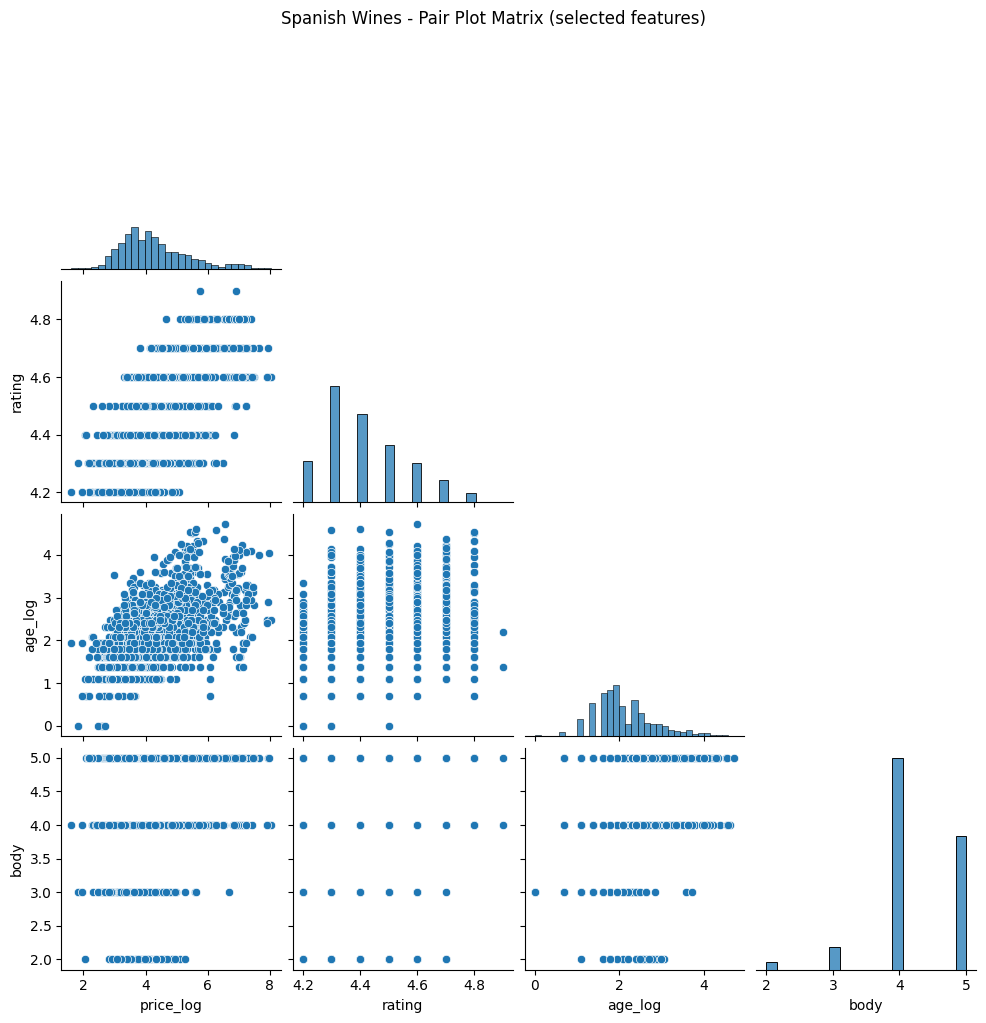

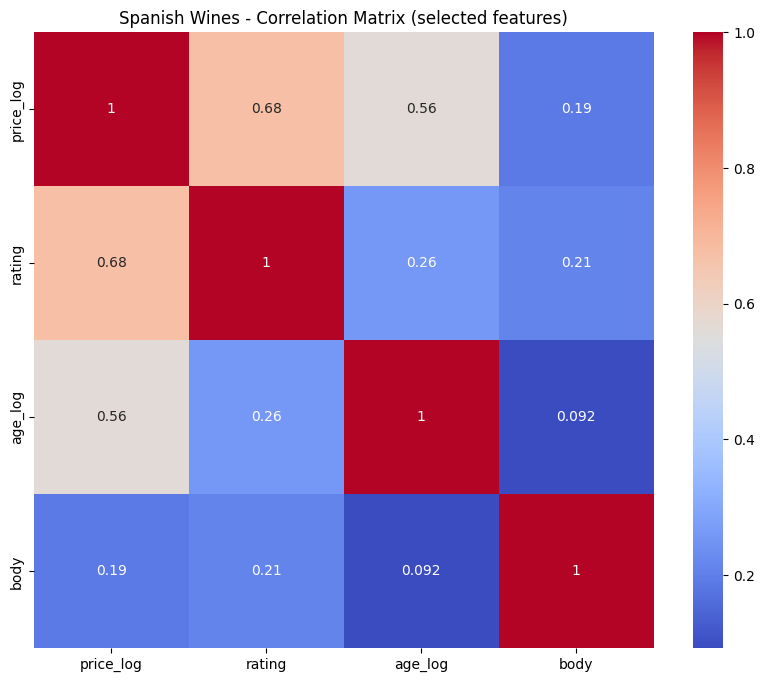

In [4]:

# I will investigate the distributions and some relationships between all features except type
df_for_pairplot = df[['price_log', 'rating', 'age_log', 'body']]

# Show a pairplot of the dataframe.
import matplotlib.pyplot as plt
import seaborn as sns    

sns.pairplot(df_for_pairplot,
             corner=True
             )
plt.suptitle("Spanish Wines - Pair Plot Matrix (selected features)", y=1.02)
plt.show()

# Show the correlation matrix of the selected features.
plt.figure(figsize=(10, 8))
sns.heatmap(df_for_pairplot.corr(), 
            annot=True, 
            cmap='coolwarm'
            )
plt.title("Spanish Wines - Correlation Matrix (selected features)")
plt.show()

**Observations:**  

The **histograms** confirm that my feature engineerig decisions where correct. *Price_log* and *age_log* show a nice normal distribution. *Price_log* shows a tiny second peak for very high prices. In a further iteration it would be interesting to analyse if there is a strong relationship of the higher prices to a certain type of wine or age or region etc. 

*Rating* is a little skewed to the lower end, but that can be expected. I will keep the original values when it is a target variable. *Body* as expected has most values in 4 and 5, and I'm still not sure if there is sufficient information in this variable. I will still keep it, and will later try to answer this question with feature cross validation. 

As for the **pair plots**, *price_log* vs. *rating* catch the eye and should give a good correlation. As expected there is also some correlation between *age_log* and *price*. 

The paiplot *age_log* vs *rating* is looks very evenly distributed across the table. Maybe older age increases rating a tiny little bit. If anything, higher *body* seems necessary to get higher *ratings*.

All observations are confirmed by the **correlation matrix**. 


### 3. Histogram showing rating imbalance (if any)


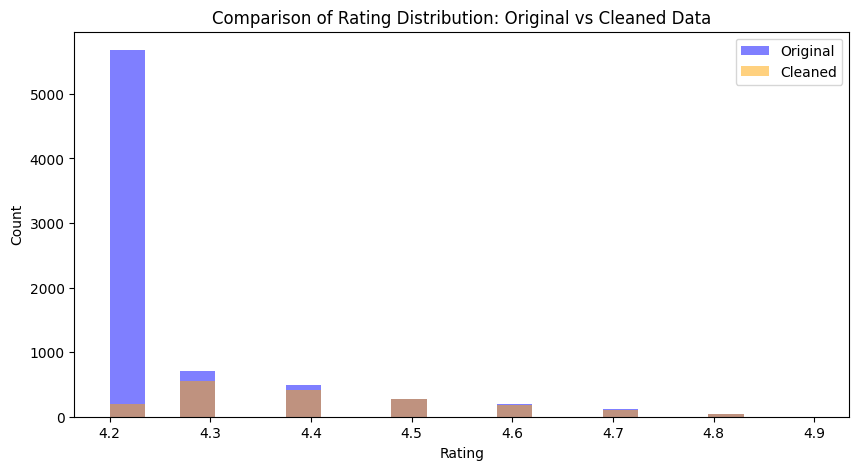

In [5]:
# I know from previous analysis that many duplicates that I removed had the same rating.
# Therefore, I want to see how the rating distribution has changed by dropping the duplicates.

# Reload the original dataframe for comparison
df_original = pd.read_csv('wines_SPA.csv')

# Compare rating between the original and the cleaned dataframe.t

plt.figure(figsize=(10,5))
plt.hist(df_original['rating'], 
         bins=20, alpha=0.5, 
         label='Original', 
         color='blue'
         )
plt.hist(df['rating'], 
         bins=20, 
         alpha=0.5, 
         label='Cleaned', 
         color='orange'
         )
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Comparison of Rating Distribution: Original vs Cleaned Data')
plt.legend()
plt.show()  

**Observations:**  

The graph shows that removing the duplicates from the dataset earlier was an essential step as it changes the *rating* distribution dramatically. 

What was originally a strongly right-skewed distribution now is a more normal distribution, only slightly skewed to lower values as can be reasonably expected. 

It feels like the overall dataset was joined together from multiple smaller ones, and some of those datasets originally came from the same origin – but obviously that is just speculation. 

However, the cleaned up version does not require additional preparation as the distribution seems intuitively representative.

### 4. Price-regression model + metrics + plot



Price Model Evaluation (Training Set):
Mean Absolute Error (MAE): 0.4697487728690505
Root Mean Squared Error (RMSE): 0.6154107403293457
R^2 Score: 0.6715735100625346

Price Model Test Set Evaluation:
Mean Absolute Error (MAE): 0.474748813262532
Root Mean Squared Error (RMSE): 0.630146725537434
R^2 Score: 0.6381804251824159


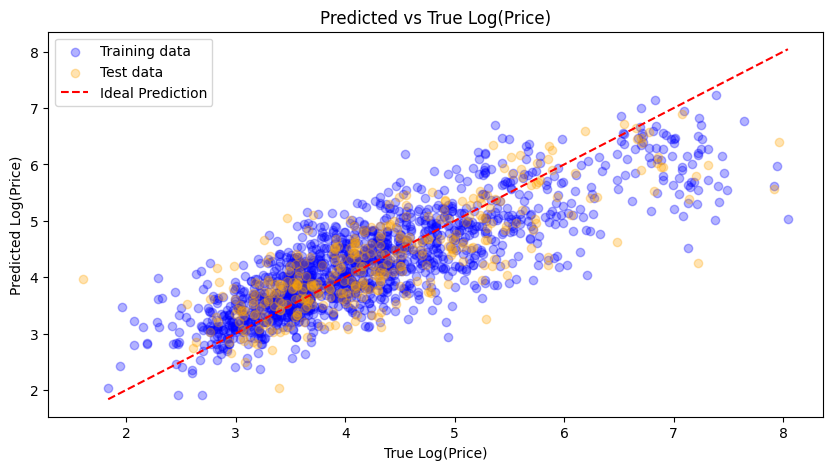

In [6]:
# Create the feature and target dataframes

df_features_price_columns = ['rating', 'age_log', 'is_nv', 'body'] + type_columns
df_features_price = df[df_features_price_columns]
# I will keep price_log as target to get better coefficients, but not scale as the values are moderate
df_target_price = df['price_log']


# Use StandardScaler to scale the features
from sklearn.preprocessing import StandardScaler
scaler_price = StandardScaler()
scaler_price.fit(df_features_price)
df_features_price_std = scaler_price.transform(df_features_price)

# Create test and training sets
# I will use 80% of the data for training and 20% for testing.
from sklearn.model_selection import train_test_split
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(df_features_price_std, 
                                     df_target_price,
                                     test_size=0.2, 
                                     random_state=0
                                     )

# Training the LinearRegression models.
from sklearn.linear_model import LinearRegression  
lr_price = LinearRegression()
lr_price.fit(X_train_price, y_train_price)
# Make predictions on training and test sets.
y_pred_price = lr_price.predict(X_train_price)
y_pred_price_test = lr_price.predict(X_test_price)

# Evaluate the models using MAE, RMSE and R^2 score.
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
mae_price = mean_absolute_error(y_train_price, y_pred_price)
rmse_price = root_mean_squared_error(y_train_price, y_pred_price)
r2_price = r2_score(y_train_price, y_pred_price)
# evaluate the test set as well
mae_price_test = mean_absolute_error(y_test_price, y_pred_price_test)
rmse_price_test = root_mean_squared_error(y_test_price, y_pred_price_test)
r2_price_test = r2_score(y_test_price, y_pred_price_test)
# Print the evaluation metrics.
print("\nPrice Model Evaluation (Training Set):")
print(f"Mean Absolute Error (MAE): {mae_price}")
print(f"Root Mean Squared Error (RMSE): {rmse_price}")
print(f"R^2 Score: {r2_price}")
print("\nPrice Model Test Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_price_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_price_test}")
print(f"R^2 Score: {r2_price_test}")

# I now viualise the predictions against the true values for both models in different colors.
plt.figure(figsize=(10,5))
plt.scatter(y_train_price, y_pred_price, alpha=0.3, color='blue', label='Training data')
plt.scatter(y_test_price, y_pred_price_test, alpha=0.3, color='orange', label='Test data')
plt.plot([y_train_price.min(), y_train_price.max()], [y_train_price.min(), y_train_price.max()],  color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.title('Predicted vs True Log(Price)')
plt.legend()
plt.show()  


**Observations:**  

The **evaluation measures** are showing the following:
In both the complex and the simpler model, MAE and RMSE are 0.47 and 0.46, respectively. This means the predicted log(price) can be expected to be off on average by this number. For the price this would mean a factor 1.6, so the actual price is on average 60% higher or lower than predicted. This sounds a lot, but given the wide price range it at least predicts the correct magnitude.  
R-squared shows that 66-67% of the log(price) variance can be explained with the model. My underdtanding is that that is an acceptable value. 

The  **visualisation** shows that the model performs better for the lower price range. The higher price range is regularly underpredicted. At the extreme lower end, there is some overpredicting.

The test dataset looks evenly distributed across the training dataset, not suggesting any over or underfitting (but see more below).


### 5. Quality-regression model + metrics + plot



Quality Model Evaluation (Training Set):
Mean Absolute Error (MAE): 0.08376939411521668
Root Mean Squared Error (RMSE): 0.10332494936417298
R^2 Score: 0.5278145065089199

Quality Model Test Set Evaluation:
Mean Absolute Error (MAE): 0.08857423733224512
Root Mean Squared Error (RMSE): 0.10875364887477564
R^2 Score: 0.4947244850796565


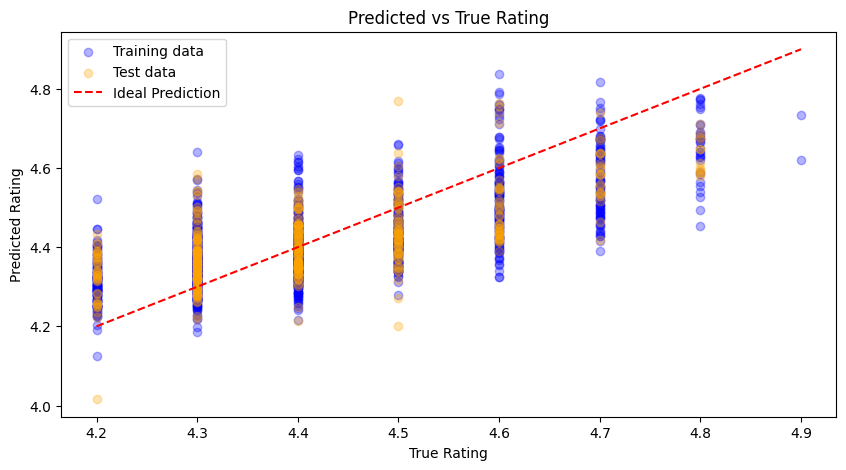

In [7]:

# Create the feature and target dataframes

features_quality_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns
df_features_quality = df[features_quality_columns]
# I won't scale rating as the values are moderate
df_target_quality = df['rating']


# Use StandardScaler to scale the features
from sklearn.preprocessing import StandardScaler
scaler_quality = StandardScaler()
scaler_quality.fit(df_features_quality)
df_features_quality_std = scaler_quality.transform(df_features_quality)

# Create test and training sets
# I will use 80% of the data for training and 20% for testing.
from sklearn.model_selection import train_test_split
X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(df_features_quality_std, 
                                     df_target_quality,
                                     test_size=0.2, 
                                     random_state=0
                                     )

# Training the LinearRegression models.
from sklearn.linear_model import LinearRegression  
lr_quality = LinearRegression()
lr_quality.fit(X_train_quality, y_train_quality)
# Make predictions on training and test sets.
y_pred_quality = lr_quality.predict(X_train_quality)
y_pred_quality_test = lr_quality.predict(X_test_quality)

# Evaluate the models using MAE, RMSE and R^2 score.
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
mae_quality = mean_absolute_error(y_train_quality, y_pred_quality)
rmse_quality = root_mean_squared_error(y_train_quality, y_pred_quality)
r2_quality = r2_score(y_train_quality, y_pred_quality)
# evaluate the test set as well
mae_quality_test = mean_absolute_error(y_test_quality, y_pred_quality_test)
rmse_quality_test = root_mean_squared_error(y_test_quality, y_pred_quality_test)
r2_quality_test = r2_score(y_test_quality, y_pred_quality_test)
# Print the evaluation metrics.
print("\nQuality Model Evaluation (Training Set):")
print(f"Mean Absolute Error (MAE): {mae_quality}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality}")
print(f"R^2 Score: {r2_quality}")
print("\nQuality Model Test Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_quality_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality_test}")
print(f"R^2 Score: {r2_quality_test}")

# I now viualise the predictions against the true values for both models in different colors.
plt.figure(figsize=(10,5))
plt.scatter(y_train_quality, y_pred_quality, alpha=0.3, color='blue', label='Training data')
plt.scatter(y_test_quality, y_pred_quality_test, alpha=0.3, color='orange', label='Test data')
plt.plot([y_train_quality.min(), y_train_quality.max()], [y_train_quality.min(), y_train_quality.max()],  color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs True Rating')
plt.legend()
plt.show()  


**Observations:**  

The model performs worse than the price model in the sense that the R-squared value is markedly lower with 52%. 

The error in the the predicted rating is on average one decimal. 

Again, both the training and the test datasets have similar evaluation scores. 

Higher ratings have a tendency to be underpredicted, and lower ratings have her a clear tendency to be be overpredicted. 



### 6. Over/under-fitting discussion and fix

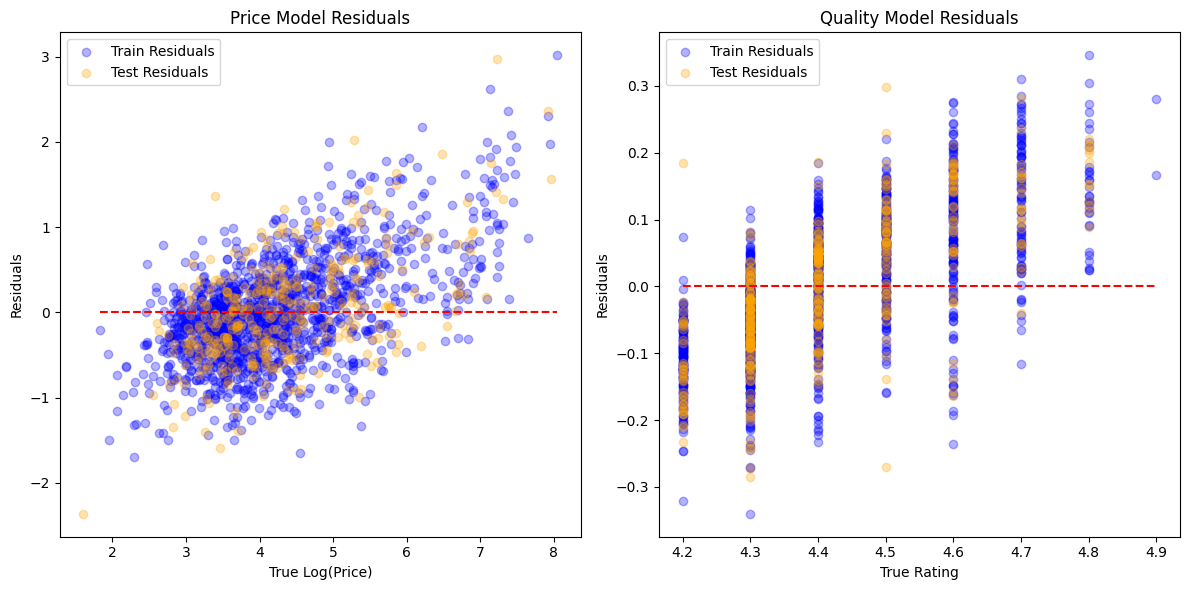

In [ ]:
# Residual plots for both models to compare training and test residuals.
# Cf. Raschka, S. et al. (2022). Machine Learning with PyTorch and Scikit-Learn. Packt. p. 288ff
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train_price, y_train_price - y_pred_price, alpha=0.3, color='blue', label='Train Residuals')
plt.scatter(y_test_price, y_test_price - y_pred_price_test, alpha=0.3, color='orange', label='Test Residuals')
plt.hlines(0, y_train_price.min(), y_train_price.max(), colors='red', linestyles='--')
plt.xlabel('True Log(Price)')
plt.ylabel('Residuals')
plt.title('Price Model Residuals')
plt.legend()    

plt.subplot(1, 2, 2)
plt.scatter(y_train_quality, y_train_quality - y_pred_quality, alpha=0.3, color='blue', label='Train Residuals')
plt.scatter(y_test_quality, y_test_quality - y_pred_quality_test, alpha=0.3, color='orange', label='Test Residuals')
plt.hlines(0, y_train_quality.min(), y_train_quality.max(), colors='red', linestyles='--')
plt.xlabel('True Rating')
plt.ylabel('Residuals')
plt.title('Quality Model Residuals')
plt.legend()

plt.tight_layout()
plt.show()




**Observations:**  

For both models, the residual distribution for the test sets is very similar to the training sets. Also, the errors are comparable, as was shown above. There are no extreme outliers. In that sense, there is no overfitting of the models, the generalisation is good. 

On the other hand, the residuals vs the x axis show a clear trend in both models – which is what we already observed when discussing the models individually. So there is still some unsatisfying underfitting.
This could mean that a simple linear regression is maybe not the best approach, or maybe more features like region should be added. 

I have tried polynomials, but that did not give better results. As we don't see overfitting, I also don't think regularisation is the way forward.

With my current knowledge I'm not sure how I could significantly improve the model, and I now run out of time to try e.g. segmented regression. 



### 7. Apply cross-validation or statistical analyses on the features or results of the regression models (advanced)

In [ ]:
# As I have a lot of features in my model for wine type, I want to see which features are stable, or whether I can remove some.
# In order to do this I will use K-Fold cross-validation to train the model multiple times and observe the variation in coefficients.
from sklearn.model_selection import KFold

# I set up K-Fold cross-validation.
# I choose 10 folds as recommended as a good practice e.g. in Géron, A. (2017). Hands-On Machine Learning with SciKit-Learn & TensorFlow. O'Reilly. p. 69.
# I feel given the size of the dataset, 5 folds would also be acceptable, but I cannot find a reference to justify this choice.
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Store coefficients from each fold
coefs = []
 
# Target variable in a numpy array
y = df_target_quality.values

# Perform K-Fold cross-validation
for train_idx, test_idx in kf.split(df_features_quality_std):
    X_train, X_test = df_features_quality_std[train_idx], df_features_quality_std[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    coefs.append(model.coef_)

# Convert to DataFrame for analysis
coefs_df = pd.DataFrame(coefs, columns=features_quality_columns)

# Analyze mean and std deviation of coefficients across folds
coef_summary = pd.DataFrame({
    'mean_coef': coefs_df.mean(),
    'std_coef': coefs_df.std(),
    'abs_mean': coefs_df.mean().abs()
}).sort_values('abs_mean', ascending=False)

# Calculate the coefficient of variation for each model coefficient (i.e. for each feature)
# by dividing the standard deviation of the coefficients by the absolute means (i.e. the variations across the folds).
# Add a small number (epsilon) just so there is no division by zero
epsilon = 1e-6
cv = coef_summary['std_coef'] / (coef_summary['abs_mean'] + epsilon)
# for each feature, check if the feature coefficient does not always have the same sign across the folds.
sign_flips = coefs_df.apply(np.sign, axis=0).nunique() > 1

# Define thresholds for stability
# cv: if cv >1, the variance is higher than the mean, so the feature is unstable
# abs_mean: if the abs(coefficient) is very small, the feature is not important
cv_threshold = 1.0
abs_mean_threshold = 0.01

# Calculate stability mask:
# cv under the threshold, abs_mean above the threshold, and no sign flips
stable_mask = (cv < cv_threshold) & (coef_summary['abs_mean'] > abs_mean_threshold) & (~sign_flips)

# Add Stable column
coef_summary['Stable'] = stable_mask

print("RESULTS FOR QUALITY MODEL\n")
print(coef_summary)

# Now I do the same for the price model.

kf = KFold(n_splits=5, shuffle=True, random_state=1)
coefs = []
y = df_target_price.values
for train_idx, test_idx in kf.split(df_features_price_std):
    X_train, X_test = df_features_price_std[train_idx], df_features_price_std[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = LinearRegression()
    model.fit(X_train, y_train)
    coefs.append(model.coef_)
coefs_df = pd.DataFrame(coefs, columns=df_features_price_columns)
coef_summary_price = pd.DataFrame({
    'mean_coef': coefs_df.mean(),
    'std_coef': coefs_df.std(),
    'abs_mean': coefs_df.mean().abs()
}).sort_values('abs_mean', ascending=False)
cv = coef_summary_price['std_coef'] / (coef_summary_price['abs_mean'] + epsilon)
sign_flips = coefs_df.apply(np.sign, axis=0).nunique() > 1
stable_mask = (cv < cv_threshold) & (coef_summary_price['abs_mean'] > abs_mean_threshold) & (~sign_flips)
coef_summary_price['Stable'] = stable_mask
print("\nRESULTS FOR PRICE MODEL\n")
print(coef_summary_price)


RESULTS FOR QUALITY MODEL

                           mean_coef  std_coef  abs_mean  Stable
price_log                   0.120067  0.001165  0.120067    True
age_log                    -0.033325  0.000970  0.033325    True
is_nv                      -0.018688  0.003888  0.018688    True
type_Pedro Ximenez          0.016128  0.001207  0.016128    True
type_Sherry                 0.014840  0.003525  0.014840    True
type_Cava                   0.014026  0.001312  0.014026    True
type_Priorat Red           -0.012689  0.000835  0.012689    True
body                        0.012473  0.001966  0.012473    True
type_Verdejo                0.007175  0.001281  0.007175   False
type_Red                    0.006363  0.000904  0.006363   False
type_Ribera Del Duero Red   0.006283  0.000744  0.006283   False
type_Sauvignon Blanc        0.005765  0.000588  0.005765   False
type_Sparkling              0.005218  0.000703  0.005218   False
type_Montsant Red          -0.005195  0.000782  0.005195   Fals

**Observations:**  

This analysis was an eye opener for me in the sense that it is possible and possibly useful to only use a selection of class values in order to keep the model as simple as possible!

The result for the Quality model shows that *price_log* is by far the most influencial feature, which could be expected.

Looking at *age_log* and *is_nv*, I am surprised that they are so closely together. *is_nv* indicates that the year was originally missing, and I imputed the values with median data. I am now wondering if that was a good idea. Maybe 'N.V.' was set on purpose for a special type of wine. A bit far fetched, but maybe this contributes to the distortion in the residuals analysis. At least in the next step I would have a closer look at the data with this in mind. 

What also stands out is that the *type* of wine only partially influences the quality rating, i.e. only a few wine types have a measurable influence on quality. 

Notably, *body* was calculated as a stable feature, so I am glad I included it. 

The situation is a little different for the price model. *Rating* and *Year* have a comparable influence on the price prediction. (I'm still not convinced if I should have used ratings as a feature.) The influence of is_nv is relatively smaller. Which means the influence on price of the wines with median age is smaller than on the ratings. 

On the other hand, more wine types influence the price compared to rating.

*Body* is not a stable feature for price. 

All in all, I learn from this exercise that even when predicting different variables on the same dataset, a thorough feature coefficient analysis helps to simplify the model, and the used feature may differ depending on what is predicted. 



